In [1]:
import os # for pulling up images and annotations
import torch
torch.cuda.is_available()

False

In [2]:
device = "mps"
print(device)

mps


In [3]:
# Hyperparameters
input_dim = 128 * 128 
latent_dim = 1024  # Size of the latent space
batch_size = 64
epochs = 20
lr = 1e-4

## Count number of images available in the dataset

In [4]:
def count_num_files_in_directory(directory):
    # List the files in the directory
    file_list = os.listdir(directory)

    # Count the number of files, ignoring subdirectories
    file_count = sum(os.path.isfile(os.path.join(directory, f)) for f in file_list)
    return file_count

In [5]:
# Specify the directory you want to count the files for
directory = 'CelebA/Img/img_align_celeba/'

number_of_images_in_celebA = count_num_files_in_directory(directory)
print("num images: ", number_of_images_in_celebA)

num images:  202599


## Define dataloader

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CelebADataset(Dataset):
    def __init__(self, directory, split='train', split_ratio = 0.8, num_samples=None, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        
        # Split data into train and test
        if split == 'train':
            self.image_filenames = self.image_filenames[:int(split_ratio * len(self.image_filenames))]
        elif split == 'test':
            self.image_filenames = self.image_filenames[int(split_ratio * len(self.image_filenames)):]
        
    def __len__(self):
#         return 20000 # if we want to use only a subset of the dataset
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.image_filenames[idx])
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        return image

# Define a transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

# Instantiate the dataset
celeba_train_dataset = CelebADataset(directory=directory, split='train', split_ratio = 0.8, transform=transform)
celeba_test_dataset = CelebADataset(directory=directory, split='test', split_ratio = 0.8, transform=transform)

# Create the DataLoader
train_dataloader = DataLoader(celeba_train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(celeba_test_dataset, batch_size=batch_size, shuffle=False)

## Display images using dataloader

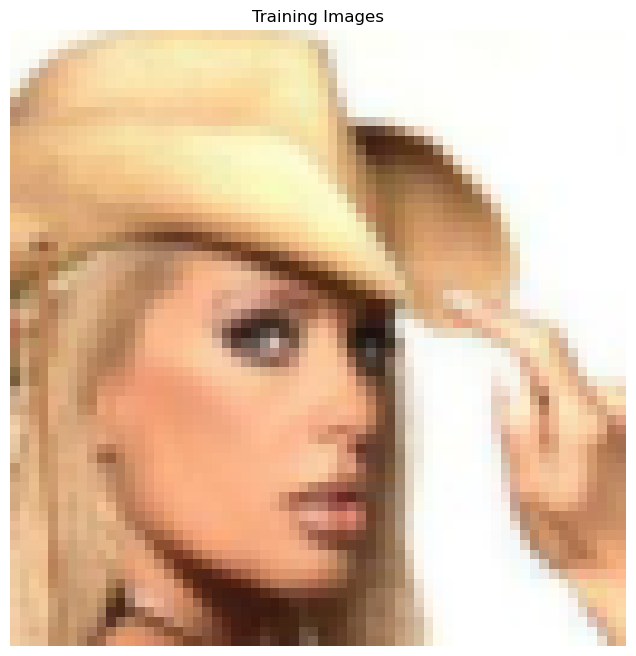

In [9]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Now you can iterate over the dataloader
for i, images in enumerate(train_dataloader):
    # Choose just one image to display from the batch
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training Images")
    # Convert the tensor to a numpy array and transpose the dimensions from (C, H, W) to (H, W, C)
    plt.imshow(images[0].permute(1, 2, 0).numpy().clip(0, 1))
    plt.show()
    
    # Break after the first image to prevent displaying all images
    if i == 0:  # display just one batch or modify as per requirement
        break

## Basic Variational Autoencoder

In [10]:
# encoder
import torch
from torch import nn
import torch.nn.functional as F
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=(2,2), padding=1) # assuming input image size is 3 x 64 x 64
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=(2,2), padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,2), padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=(2,2), padding=1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=(3,3), stride=(2,2), padding=1)
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.fc_mu = nn.Linear(2048, latent_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.batchnorm1(x))
        x = self.conv2(x)
        x = F.relu(self.batchnorm2(x))
        x = self.conv3(x)
        x = F.relu(self.batchnorm3(x))
        x = self.conv4(x)
        x = F.relu(self.batchnorm4(x))
        x = self.conv5(x)
        x = F.relu(self.batchnorm5(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        return mu

In [11]:
# decoder
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 2048)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1)
        self.batchnorm4 = nn.BatchNorm2d(32)
        self.deconv5 = nn.ConvTranspose2d(32, 32, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1)
        self.batchnorm5 = nn.BatchNorm2d(32)
        self.conv = nn.Conv2d(32, 3, kernel_size=(3,3), stride=(1,1), padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, 2, 2) # reshaping to match the corresponding encoder shape
        x = self.deconv1(x)
        x = F.relu(self.batchnorm1(x))
        x = self.deconv2(x)
        x = F.relu(self.batchnorm2(x))
        x = self.deconv3(x)
        x = F.relu(self.batchnorm3(x))
        x = self.deconv4(x)
        x = F.relu(self.batchnorm4(x))
        x = self.deconv5(x)
        x = F.relu(self.batchnorm5(x))
        x = self.conv(x)
        reconstruction = torch.tanh(x) # Using sigmoid for final layer to output values between 0 and 1
        return reconstruction

In [12]:
# autoencoder
class AE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def forward(self, x):
        mu = self.encoder(x)
        return self.decoder(mu)

In [14]:
def loss_fn(recon_x, x):
    loss = F.mse_loss(recon_x, x, reduction='mean')
    return loss

In [15]:
import csv

# Function to save data to CSV
def save_to_csv(epoch, loss, filename):
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, loss])

# Example usage in a training loop
filename = '200k_training_log.csv'

# Initialize or clear the file with headers
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Loss"])

In [16]:
def train_ae(model, dataloader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, data in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch = model(data)
            loss = loss_fn(recon_batch, data)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))
        save_to_csv(epoch,  train_loss / len(dataloader.dataset), filename)
    return model


# Training

In [ ]:
from torchvision import datasets, transforms

train_loader = train_dataloader
model = AE(latent_dim)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train the AE
vae_model = train_vae(model, train_loader, optimizer, epochs)

# Image Reconstruction on Test

In [ ]:
test_dataloader = DataLoader(celeba_test_dataset, batch_size=36, shuffle=True)
img = next(iter(test_dataloader))

In [ ]:
test_examples = img.to(device)
reconstruction = model(test_examples)
reconstruction = reconstruction.to('cpu')
reconstruction = reconstruction.to('cpu')
print(img.shape)
print(reconstruction.shape)
vutils.save_image(reconstruction.data,
                  os.path.join(
                      "./",
                      f"recons1.png"),
                  normalize=True,
                  nrow=6)
vutils.save_image(test_examples.data,
                  os.path.join(
                      "./",
                      f"img1.png"),
                  normalize=True,
                  nrow=6)

# Save Model

In [27]:
torch.save(model.state_dict(), 'model.pt')